In [1]:
%load_ext Cython
# https://kaushikghose.wordpress.com/2014/12/08/get-more-out-of-cython/
# http://nealhughes.net/cython1/
# http://codereview.stackexchange.com/questions/43413/optimize-cython-code-with-np-ndarray-contained
# https://github.com/bendmorris/pybioclim/blob/master/src/coords.pyx
%matplotlib inline

# This is a demo for the GPS data pre-processing
#### Author: 
#### Date:  Feb 2017

In [2]:
import math
import numpy as np
import pandas as pd
import logging
from datetime import datetime, timezone, timedelta
import pyproj, utm
import os
import pytz
from itertools import compress
from numba import vectorize, guvectorize, jit, autojit, float32, float64, double, int64, int32


GEOLIFE_DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
GMT = pytz.timezone('GMT')
BEIJING_TIMEZONE = pytz.timezone('Asia/Shanghai')
ROLLING_WINDOW_SIZE = 10
ROLLING_WINDOW_SECONDS = 10.
# http://www.latlong.net/lat-long-utm.html

TIME_GAP_FOR_ONE_TRIP = 60.  # this defines the time gap between two trips in seconds


In [3]:
def df_shift_one(df, columns):
    # get the lag 1 value for columns
    df_shift = df[columns].shift(1, axis=0)
    new_columns = {}
    for col in columns:
        new_columns[col] = col+"_last"
        if col+"_last" in df.columns.values:
            del df[col+"_last"]
    df_shift = df_shift.rename(columns=new_columns)
    # set the first record to be same as first row
    df_shift.ix[df_shift.index[0], :len(columns)] = list(df.ix[df_shift.index[0], columns])
    df = pd.concat([df, df_shift], axis=1)
    return df


def split_trips_by_time(df, time_column='timestamp', time_gap_threshold_sec = TIME_GAP_FOR_ONE_TRIP):
    # the time_column is the column name used as time stamp
    # time_gap_threshold_sec is threshold in second to tell whether timestamp gap is large enough
    # to be considered as another trip
    # :return: A dictionary where the keys are trip ID within the same file
    df2 = df_shift_one(df, columns=[time_column])
    df2['timegap'] = df2[time_column] - df2[time_column+'_last']
    trip_index = df2.ix[df2['timegap'] > time_gap_threshold_sec].index
    df_dict = {}
    trip_index_cutoff = list(set([df2.index[0]] + list(trip_index) + [df2.index[-1]+1]))  # use unique index for robustness
    trip_index_cutoff.sort()
    numoftrips = len(trip_index_cutoff) -1
    trip_internal_id = list(map(lambda x: "suf_0"+str(x) if x<10 else "suf_"+str(x), range(numoftrips)))
    for i in range(len(trip_internal_id)):
        # intentionally remove first data point, often that point is prone to GPS recording error
        df_dict[trip_internal_id[i]] = df.ix[(trip_index_cutoff[i]+1):(trip_index_cutoff[i+1]-1)]
    return df_dict


def calc_distance(lat1, lon1, lat2, lon2, unit="km"):
    """
    The function returns the distance between two lat, long coordinates in miles or kilometers

    :param lat1: latitude info, in geo reference WGS84
    :param lon1: longitude info, in geo reference WGS84
    :type arg1: float
    :type arg2: float
    :type arg3: float
    :type arg4: float
    :return: the distance between two coordinates in mile or km
    :rtype: float

    :Example:
    >>> calc_distance(40.920320, -74.293288, 40.730975, -74.001509, "km")
    """
    error_msg = "The unit for distance has to be one of mile and km"
    if unit not in ['mile', 'km']:
        raise ValueError(error_msg)
    theta = lon1 -lon2
    dist_angle = math.sin(math.radians(lat1))*math.sin(math.radians(lat2)) \
            + math.cos(math.radians(lat1))*math.cos(math.radians(lat2)) \
            * math.cos(math.radians(theta))
    dist_angle = max(-1, min(dist_angle, 1))
    dist_angle = math.acos(dist_angle)
    dist_angle = math.degrees(dist_angle)
    mile = dist_angle * 60.0 * 1.1515
    if mile < 1e-4: mile = 0
    km = mile * 1.609344
    if unit == 'mile':
        return mile
    elif unit == 'km':
        return km
    else:
        raise ValueError(error_msg)


## Vectorized version of distance calculation for speed boost
#  nopython=True to ensure there is no Python run-time
@vectorize([float32(float32, float32, float32, float32),
          float64(float64, float64, float64, float64)],
          nopython=True)
def calc_distance_km_withnumba(lat1, lon1, lat2, lon2):
    """
    This is vectorized version
    """
    theta = lon1 - lon2
    dist_angle = math.sin(math.radians(lat1))*math.sin(math.radians(lat2)) \
            + math.cos(math.radians(lat1))*math.cos(math.radians(lat2)) \
            * math.cos(math.radians(theta))
    dist_angle = max(-1, min(dist_angle, 1))
    dist_angle = math.acos(dist_angle)
    dist_angle = math.degrees(dist_angle)
    mile = dist_angle * 60.0 * 1.1515
    if mile < 1e-4: mile = 0.0
    km = mile * 1.609344
    return km


def load_gps_plt_data2array(file_dir):
    """
    Load in the gps data in the log file if file directory is given
    Field 1: Latitude in decimal degrees.
    Field 2: Longitude in decimal degrees.
    Field 3: All set to 0 for this dataset.
    Field 4: Altitude in feet (-777 if not valid).
    Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.
    Field 6: Date as a string.
    Field 7: Time as a string.
    >>> x_ = load_gps_plt_data2array(file_dir='./data_GeoLife/001/Trajectory/20081023055305.plt')
    """
    gpsdata = np.genfromtxt(file_dir,
                            delimiter=',',
                            skip_header=6,
                            dtype="f8,f8,f8,f8,f8,S10,S8",
                            #dtype=('<f8','<f8','<f8','<f8','<f8','|S10', '|S8'),
                            #dtype=(float,float,float,float,float,'|S10','|S10'),
                            usecols = range(7), # select your own columns
                            names=['lat', 'lon', 'dummy1', 'alt', 'days_passed', 'date_str', 'time'],
                            autostrip=True)
    return gpsdata


# Filter the noise using rolling median on array
def index_filter_by_median_on_array(signal, threshold=3):
    df = pd.DataFrame(np.array(signal))
    df['rollmedian'] = df.rolling(10, min_periods=3).median().fillna(0)
    difference = (df[0] - df['rollmedian'])/(df['rollmedian'] + 0.01)
    outlier_idx = (difference > threshold) & (df[0] > df[0].quantile(.99))
    # outlier_idx is bolean list
    return list(compress(range(len(outlier_idx)), outlier_idx))


# Filter the noise using rolling median on data frame
def df_filter_by_median(df, column='speed', threshold=4.):
    # column is the column name used in the rolling-window to filter 
    # outliers
    # df_filter_by_median(df=append_speed(gpsdata))[0]
    df2 = pd.DataFrame(df[column])
    df2[column+'_roll_median'] = df2.rolling(ROLLING_WINDOW_SIZE, min_periods=5).median().fillna(0)
    difference = (df2[column] - df2[column+'_roll_median'])/(df2[column+'_roll_median'] + 0.01)
    outlier_idx = df2.ix[(difference > threshold) & (df2[column] > df2[column].quantile(.99))].index
    df_dropped = df2.ix[outlier_idx]
    df = df.drop(outlier_idx)
    return df, df_dropped


@vectorize([float64(float64,float64,float64,float64,float64,float64)], nopython=True)
def get_turning_angle_vec(a0, a1, b0, b1, c0, c1):
    # a0, a1 are the first points' lat long values
    # same for b0,b1, c0,c1
    ab = calc_distance_km_withnumba(a0, a1, b0, b1)
    bc = calc_distance_km_withnumba(b0, b1, c0, c1)
    ac = calc_distance_km_withnumba(a0, a1, c0, c1)
    return (180. - math.acos((ab**2. + bc**2. - ac **2.)/(2. * ab * bc)) * 180. / math.pi)


@jit('void(f8[:, :, :], f8)')
def get_angle_from_multi_points(points, rolling_window_seconds):
    """
    :points: It is an n X 3 array, where n has to be >=3, lat, long, timestamp, the columns
            must be exactly in that order
    :rolling_window_seconds: float, is the # of seconds for rolling forward
            the current record and find the sharpest turning angle
    >>> Sample usage:
        points = np.array(gpsdata[:900].iloc[:, :3])
        get_angle_from_multi_points(points, rolling_window_seconds=ROLLING_WINDOW_SECONDS)
    """
    angles = points[:, 0] * 0.
    visted = points[:, 0] * 0.
    counter = 0
    i_ = 0
    for i in range(len(points)-2):
        if i >= i_:
            angle = 0.
            turn_tm = 0.
            for j in range(i+2, len(points)):
                if points[j, 2]-points[i, 2] > rolling_window_seconds:
                    for ii in range(i+1, j):
                        angle_ = get_turning_angle_vec(points[i,0], points[i,1], 
                                                       points[ii,0], points[ii,1],
                                                       points[j,0], points[j, 1])
                        if angle_ > angle:
                            angle = angle_
                            turn_tm = points[ii,2]  # record the timestamp for the turning point
                            i_ = ii
                    break
                else:
                    continue
            angles[i_] = angle
        else:
            continue
        # record angle if that turning timestamp hasn't been used
        #if turn_tm > 0. and np.round(turn_tm,3) not in visted:  # not used for JIT reason
        #if turn_tm > 0. and np.min(np.abs(visted - np.round(turn_tm,3))) > 1e-3:  # not used for JIT rea
        #    angles[i_] = angle
        #    visted[counter] = np.round(turn_tm,3)
        #    counter += 1
    return angles


In [4]:
def load_gps_plt_data(file_dir):
    """
    Load in the gps data in the log file if file directory is given
    Field 1: Latitude in decimal degrees.
    Field 2: Longitude in decimal degrees.
    Field 3: All set to 0 for this dataset.
    Field 4: Altitude in feet (-777 if not valid).
    Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.
    Field 6: Date as a string.
    Field 7: Time as a string.
    >>> x_ = load_gps_plt_data(file_dir='./data_GeoLife/001/Trajectory/20081023055305.plt')
    """
    # gpsdata = pd.read_csv(file_dir, sep=',', header=None, skiprows=6)  # do not use any row for column names by header=None
    gpsdata = pd.read_csv(file_dir, sep=',', header=None, skiprows=6, names=['lat', 'lon', 'dummy1', 'alt', 'days_passed', 'date_str', 'time'])
    gpsdata['datetime'] = gpsdata.ix[:, 5] + ' ' + gpsdata.ix[:, 6]
    # to convert time to Beijing time
    # gpsdata['datetime'] = pd.DatetimeIndex(pd.to_datetime(gpsdata['datetime'],format='%Y-%m-%d %H:%M:%S'),tz='UTC').tz_convert('Asia/Shanghai')
    gpsdata['datetime'] = pd.DatetimeIndex(pd.to_datetime(gpsdata['datetime'],format='%Y-%m-%d %H:%M:%S'),tz='UTC')
    # sample conversion from unix epoch to datetime
    # np.array([1368431149, 1368431150]).astype('datetime64[s]')
    # convert to UTC epoch time in million seconds, first conversion below converts to nano second
    gpsdata['timestamp'] = gpsdata['datetime'].astype(np.int64)/(10**6)
    # convert to UTC epoch time in seconds, where decimal places are for millisecond
    gpsdata['timestamp'] = gpsdata['timestamp'].astype(np.int64) / 1000.
    # remove the records with missing date time
    gpsdata = gpsdata[(gpsdata['timestamp'] > 0) & (gpsdata['lon'].notnull()) & (gpsdata['lat'].notnull())]
    # gpsdata.index = [i for i in range(gpsdata.shape[0])]  # may slow down calculations
    return gpsdata


def append_speed(gpsdata):
    # The data frame assumes the column names to be precisely as used below
    # the gpsdata is a pandas data frame
    gpsdata = df_shift_one(gpsdata, columns=['lat', 'lon', 'timestamp'])
    gpsdata['distance'] = np.nan
    gpsdata['time_delta_sec'] = gpsdata['timestamp'] - gpsdata['timestamp_last']
    # x_ = 1187142632
    # scale_ = gpsdata.ix[gpsdata.index[0], 'timestamp'] / x_
    # scale_ = min([1.0, 10.0, 100.0, 1000.0], key=lambda x:abs(math.log(x)-math.log(scale_)))
    # gpsdata['time_delta_sec'] = gpsdata['time_delta_sec'] / scale_
    try:
        # use the vectorized version first
        gpsdata['distance'] = calc_distance_km_withnumba(gpsdata['lat'], 
                                                         gpsdata['lon'], 
                                                         gpsdata['lat_last'], 
                                                         gpsdata['lon_last'])
    except NameError:
        print("Use for-loop to calculate distance and speed")
        for i in gpsdata.index:
            value_ = calc_distance(gpsdata.ix[i, 'lat'],
                                              gpsdata.ix[i, 'lon'],
                                              gpsdata.ix[i, 'lat_last'],
                                              gpsdata.ix[i, 'lon_last'], 'km')
            gpsdata.ix[i,'distance'] = (value_)
    
    gpsdata.ix[gpsdata.time_delta_sec <=0, 'time_delta_sec'] = (0.001)
    del gpsdata['lat_last']
    del gpsdata['lon_last']
    del gpsdata['timestamp_last']
    # get the location of index for the 
    # location = list(compress(range(len(gpsdata['time_delta_sec'] > 3600)), gpsdata['time_delta_sec'] > 3600))
    # gpsdata.ix[gpsdata['time_delta_sec'] > TIME_GAP_FOR_ONE_TRIP, ['distance', 'time_delta_sec']] = (0., 0.001)
    gpsdata['speed'] = 3600. * gpsdata['distance']/gpsdata['time_delta_sec']
    # speed unit is km/h
    return gpsdata


def append_speed_full(gpsdata):
    # add more features
    gpsdata = append_speed(gpsdata)
    angles = get_angle_from_multi_points(np.array(gpsdata[['lat', 'lon', 'timestamp']]), 
                                         rolling_window_seconds=ROLLING_WINDOW_SECONDS)
    gpsdata['turn_angle_degrees'] = angles
    return gpsdata

##### Use Ramer-Douglas-Peucker algorithm to get the rough simplied path, pure python version

In [5]:
@jit('void(f8[:], f8[:], f8[:])')
def utm_from_latlong_vec(lats, lons, res):
    # vecorize the lat long to utm calcultions
    for i in range(len(lats)):
        res[i] = utm.from_latlon(lats[i], lons[i])
    return res


def point_line_distance(point, start, end):
    # This is to calculate the point to line distance
    # :point: Tuple (float, float), lat, long of the point
    # :start: Tuple (float, float), lat, long of the starting point
    # :end: Tuple (float, float), lat, long of the ending point
    if np.array_equal(start, end):
        return calc_distance(point[0], point[1], start[0], start[1])
    else:
        point_raw = np.array(point) + 0.
        point = utm.from_latlon(point[0], point[1])
        zone_1, zone_2 = point[2:]
        point = np.array(point[:2])
        start = np.array(utm.from_latlon(start[0], start[1])[:2])
        end = np.array(utm.from_latlon(end[0], end[1])[:2])
        xdis = end[0] - start[0]
        ydis = end[1] - start[1]
        shortestlength = ((xdis * (point[0] - start[0])) + (ydis * (point[1] - start[1]))) / ((xdis ** 2.) + (ydis ** 2.)) 
        perpen_point = [None, None]
        perpen_point[0] = start[0] + xdis * shortestlength 
        perpen_point[1] = start[1] + ydis * shortestlength
        perpen_point = np.array(utm.to_latlon(perpen_point[0], perpen_point[1], zone_1, zone_2)[:2])
        return calc_distance(point_raw[0], point_raw[1], perpen_point[0], perpen_point[1])


def rdp(points, epsilon):
    """
    Reduces a series of points to a simplified version. It loses detail, but
    maintains the general shape of the series.
    : points is an array of tuple/list/array (lat,long)
    : epsilong is the threshold for controling how simplied the path will be, the higher
        the simplier it gets
    """
    distmax = 0.0
    idx = 0
    visited = {}
    results = []
    
    points_tupled = tuple([points[0][0],points[0][1],points[-1][0],points[-1][1]])
    if points_tupled in visited:
        results = visited[points_tupled]
    else:
        # find the highest point
        for i in range(1, len(points) - 1):
            d = point_line_distance(points[i], points[0], points[-1])
            if d > distmax:
                idx = i
                distmax = d
        if distmax >= epsilon:
            # split path search from left and right, each result includes start,end points
            results = rdp(points[:idx+1], epsilon)[:-1] + rdp(points[idx:], epsilon)
        else:
            results = [points[0], points[-1]]
        visited[points_tupled] = results
    return results


##### Use Ramer-Douglas-Peucker algorithm to get the rough simplied path, vectorized version.

In [6]:
@vectorize([float32(float32, float32, float32, float32, float32, float32),
            float64(float64, float64, float64, float64, float64, float64)],
            nopython=True)
def point_line_distance_vec(pt0, pt1, st0, st1, end0, end1):
    # This is to calculate the point to line distance
    # : nopython: This is to ensure no python code for compilation
    # :point: Tuple (float, float), lat, long of the point
    # :start: Tuple (float, float), lat, long of the starting point
    # :end: Tuple (float, float), lat, long of the ending point
    point = [pt0, pt1]
    start = [st0, st1]
    end = [end0, end1]
    if st0==end0 and st1==end1:
        return calc_distance_km_withnumba(pt0, pt1, st0, st1)
    else:
        xdis = end0 -st0
        ydis = end1 - st1
        shortestlength = ((xdis * (pt0-st0)) + (ydis * (pt1 - st1))) / ((xdis ** 2.) + (ydis ** 2.)) 
        perpen_point0 = st0 + xdis * shortestlength 
        perpen_point1 = st1 + ydis * shortestlength
        return calc_distance_km_withnumba(pt0, pt1, perpen_point0, perpen_point1)


# rdp function with vectorization flavor, but hard to vectorize it without python run time
@jit(locals=dict(points=double[:,:], epsilon=double, results=double[:,:]), nopython=True)
def rdp_vec(points, epsilon):
    """
    Reduces a series of points to a simplified version. It loses detail, but
    maintains the general shape of the series.
    : points is an array of tuple/list/array (lat,long)
    : epsilong is the threshold for controling how simplied the path will be, the higher
        the simplier it gets
    """
    distmax = 0.0
    idx = 0
    # results are pre-defined as in put or initial blank
    # find the highest point
    points_between = points[1:-1]
    distances = point_line_distance_vec(points_between[:,0],points_between[:,1],
                                       points[0][0], points[0][1],
                                       points[-1][0], points[-1][1])
    d = np.max(distances)
    if d > distmax:
        idx = distances.argmax()+1
        distmax = d
    if distmax >= epsilon:
        # split path search from left and right, each result includes start,end points
        results = np.vstack((rdp_vec(points[:idx+1], epsilon)[:-1], rdp_vec(points[idx:], epsilon)))
    else:
        results = np.vstack((points[0], points[-1]))
    return results


### Load in GPS Data

In [7]:
gps = load_gps_plt_data(file_dir='./data_GeoLife/001/Trajectory/20081023055305.plt')
gpsdata = gps.ix[:, [0,1,8]]

In [8]:
gpsdata_tuple = df_filter_by_median(df=append_speed(gpsdata))
gpsdata = gpsdata_tuple[0][gpsdata.columns.values]  # gpsdata is now filtered
gpsdata_deleted = gpsdata_tuple[1]
gpsdata_dict = split_trips_by_time(df=gpsdata, time_column='timestamp', time_gap_threshold_sec = TIME_GAP_FOR_ONE_TRIP)

In [9]:
for d_ in gpsdata_dict:
    # re-insert the speed and lagged info to the filtered gps data
    gpsdata_dict[d_] = append_speed_full(gpsdata_dict[d_])

##### Test the calculation speed and performance for implementing RDP algorithm

In [10]:
points = np.array(gpsdata.ix[:, :2])
%timeit rdp_vec(np.array(gpsdata.ix[:, :2]), 0.5)
%timeit rdp(np.array(gpsdata.ix[:, :2]), 0.5)
%timeit point_line_distance_vec(points[1:-1][:,0],points[1:-1][:,1], \
                                           points[0][0], points[0][1], \
                                           points[-1][0], points[-1][1])
%timeit map(lambda i: point_line_distance(points[i], points[0], points[-1]), range(1, len(points) - 1))
np.array_equal(rdp_vec(np.array(gpsdata.ix[:, :2]), 0.5), rdp(np.array(gpsdata.ix[:, :2]), 0.5))  # exepct True


The slowest run took 508.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 3.19 ms per loop
1 loop, best of 3: 202 ms per loop
1000 loops, best of 3: 867 µs per loop
The slowest run took 4.51 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 811 ns per loop


True

### The gpsdata_dict is the filtered GPS data in dictionary format. Each identifies the each trip within the GPS data file.

Distance traveled in the 1-th trip is 1.505 km with 143 data points in 0.1461 hours
Distance traveled in the 2-th trip is 6.6737 km with 616 data points in 0.6233 hours
Distance traveled in the 3-th trip is 0.079 km with 190 data points in 0.2542 hours


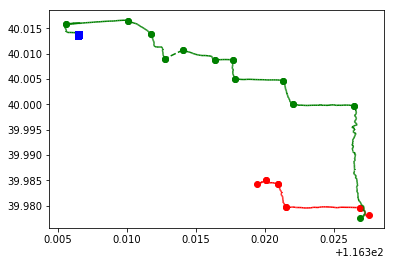

In [11]:
# plot the path
import matplotlib.pyplot as plt

plottypes = ["r--", "g--","bs", "ro"]
color_types = ["r", "g","b", "r"]
rdp_threshold = 0.05  # unit is km
keys_ = list(gpsdata_dict.keys())

for i in range(len(keys_)):
    #plt.scatter(lng, lat)
    plottype_ = plottypes[i % 3]
    gps_ = gpsdata_dict[keys_[i]]
    gps_with_speed_ = append_speed(gps_)
    print("Distance traveled in the {}-th trip is {} km with {} data points in {} hours".format(
                    i+1,
                    round(gps_with_speed_['distance'].sum(),4),
                    gps_with_speed_.shape[0],
                    round((gps_with_speed_['timestamp'].max()-gps_with_speed_['timestamp'].min())/3600.,4)))
    for ii in range(gps_.shape[0]):
        lat, lng = tuple(gps_.iloc[ii, :2])
        try:
            n_lat, n_lng = tuple(gps_.iloc[ii+1, :2])
            plt.plot((lng, n_lng),(lat, n_lat), plottype_)
        except IndexError:
            pass
    # plot the rdp simplied path
    #path_ = rdp(np.array(gps_.ix[:, :2]), rdp_threshold)
    path_ = rdp_vec(np.array(gps_.ix[:, :2]), rdp_threshold)
    for ii in range(len(path_)):
        lat, lng = tuple(path_[ii])
        try:
            n_lat, n_lng = tuple(path_[ii+1])
            plt.plot((lng, n_lng),(lat, n_lat), color_types[i % 3]+"o")
        except IndexError:
            pass
plt.show()


In [12]:
# Speed Test and Validate calculation through JIT compiler

gpsdata2 = np.array([[53.3854313241815,-1.4932127483203013, 1384209632918], 
                    [53.38609362252086,-1.4951305729482556, 1384209650218]])

distance = sum([calc_distance(gpsdata2[i][0], 
                              gpsdata2[i][1], 
                              gpsdata2[i+1][0], 
                              gpsdata2[i+1][1], "km") 
                for i in range(len(gpsdata2)-1)])
print("Distance traveled on GPS is {} km through for-loop".format(distance))


# Test JIT version to see if it matches results from above
gpsdata3 = np.array([[53.3854313241815,-1.4932127483203013, 53.38609362252086,-1.4951305729482556], 
                    [53.3854313241815,-1.4932127483203013, 53.38609362252086,-1.4951305729482556]])
distance2 = sum(calc_distance_km_withnumba(gpsdata3[:, 0], 
                              gpsdata3[:, 1], 
                              gpsdata3[:, 2], 
                              gpsdata3[:, 3])) * 0.5
print("Distance traveled on GPS is {} km through JIT".format(distance2))


### Speed Comparison between Vectorized and Regular for-loop Versions
for i in range(10000):
    if i == 0:
        gpsdata2_test = gpsdata2 + 0.
    else:
        gpsdata2_test = np.vstack((gpsdata2, gpsdata2_test))

for i in range(10000):
    if i == 0:
        gpsdata3_test = gpsdata3 + 0.
    else:
        gpsdata3_test = np.vstack((gpsdata3, gpsdata3_test))

%timeit sum([calc_distance(gpsdata2_test[i][0], \
                              gpsdata2_test[i][1], \
                              gpsdata2_test[i+1][0], \
                              gpsdata2_test[i+1][1], "km") \
                for i in range(len(gpsdata2_test)-1)])
%timeit np.sum(calc_distance_km_withnumba(gpsdata3_test[:, 0], \
                                  gpsdata3_test[:, 1], \
                                  gpsdata3_test[:, 2], \
                                  gpsdata3_test[:, 3]))

Distance traveled on GPS is 0.14696399289179068 km through for-loop
Distance traveled on GPS is 0.14696399289179068 km through JIT
10 loops, best of 3: 84.4 ms per loop
100 loops, best of 3: 2.41 ms per loop





# Below are the codes for using Cython to boost speed

In [13]:
%%cython
# or use %%cython -a for more details

cimport cython

cdef extern from "math.h":
    double sin(double)
    double cos(double)
    double acos(double)
    double atan2(double, double)

cdef double pi = 3.141592654

@cython.cdivision(True)
cdef double radians(double deg):
    return deg/180.*(pi)

@cython.cdivision(True)
cdef double degrees(double rad):
    return rad * (180.0 / pi)

# from libc.math cimport acos, degrees, sin, cos, radians

cdef double calc_distance_km_c(double lat1, double lon1, 
                    double lat2, double lon2):
    cdef double theta, dist_angle, mile, km
        
    theta = lon1 -lon2
    dist_angle = sin(radians(lat1))* sin(radians(lat2)) \
            + cos(radians(lat1))* cos(radians(lat2)) \
            * cos(radians(theta))
    dist_angle = max(-1, min(dist_angle, 1))
    dist_angle = acos(dist_angle)
    dist_angle = degrees(dist_angle)
    mile = dist_angle * 60.0 * 1.1515
    km = mile * 1.609344
    return km

print(calc_distance_km_c(40.920320, -74.293288, 40.730975, -74.001509))

32.34059622449445


In [14]:
%%cython

cimport numpy as np
cimport cython
from libc.time cimport difftime
import calendar, time


cdef extern from "math.h":
    double sin(double)
    double cos(double)
    double acos(double)
    double atan2(double, double)
    double log(double)

cdef double pi = 3.141592654

@cython.cdivision(True)
cdef double radians(double deg):
    return deg/180.*(pi)

@cython.cdivision(True)
cdef double degrees(double rad):
    return rad * (180.0 / pi)

# from libc.math cimport acos, degrees, sin, cos, radians

cdef double calc_distance_km_c(double lat1, double lon1, 
                    double lat2, double lon2):
    cdef double theta, dist_angle, mile, km
        
    theta = lon1 -lon2
    dist_angle = sin(radians(lat1))* sin(radians(lat2)) \
            + cos(radians(lat1))* cos(radians(lat2)) \
            * cos(radians(theta))
    dist_angle = max(-1, min(dist_angle, 1))
    dist_angle = acos(dist_angle)
    dist_angle = degrees(dist_angle)
    mile = dist_angle * 60.0 * 1.1515
    km = mile * 1.609344
    return km

#cdef np.ndarray h = np.zeros([xmax, ymax], dtype=DTYPE)

def speed_cal_c(np.ndarray[np.float_t, ndim=2] gpsdata):
    """
    :param gpsdata: numpy 2 dimensional gps data, lat, long and UTC timestamp
    :return Speed in the gps data, km/hour
    """
    cdef int len_ = len(gpsdata)-1
    cdef double distance = 0.
    cdef double scale2sec, x_, x, run_time_in_sec, speed
    for i in range(len_):
        distance += calc_distance_km_c(gpsdata[i][0], gpsdata[i][1], gpsdata[i+1][0], gpsdata[i+1][1])
    # x_ = calendar.timegm(time.gmtime())
    x_ = 1187142632
    scale_ = gpsdata[0, 2] / x_
    scale_ = min([1.0, 10.0, 100.0, 1000.0], key=lambda x:abs(log(x)-log(scale_)))
    run_time_in_sec = max(gpsdata[:, 2])/scale_ - min(gpsdata[:, 2])/scale_
    speed = (distance / (run_time_in_sec / 3600.0))
    print("The distance traveled is {} km".format(distance))
    print("The time traveled is {} seconds".format(run_time_in_sec))
    print("The returned speed is in unit km/h")
    return speed


In [15]:
speed_cal_c(gpsdata2)

The distance traveled is 0.14696396221255864 km
The time traveled is 17.299999952316284 seconds
The returned speed is in unit km/h


30.582096267253124